In [18]:
!pip install statsmodels

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
df = pd.read_csv('Retail Sales Forecasting.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


# Data Cleaning

In [3]:
df.columns = ['Month' , 'Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.shape

(107, 2)

In [5]:
df.isna().sum()

,0
Month,1
Sales,2


In [7]:
df.dropna(inplace = True)

In [8]:
df.isna().sum()

,0
Month,0
Sales,0


In [9]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [10]:
df.shape

(105, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


Convert datatype of Month Column from object -> Datetime

In [12]:
df['Month'] = pd.to_datetime(df['Month'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   105 non-null    datetime64[ns]
 1   Sales   105 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.5 KB


In [14]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


use month as index value

In [15]:
df.set_index('Month' , inplace = True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [16]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


# Visualizing Sales


<Axes: xlabel='Month'>

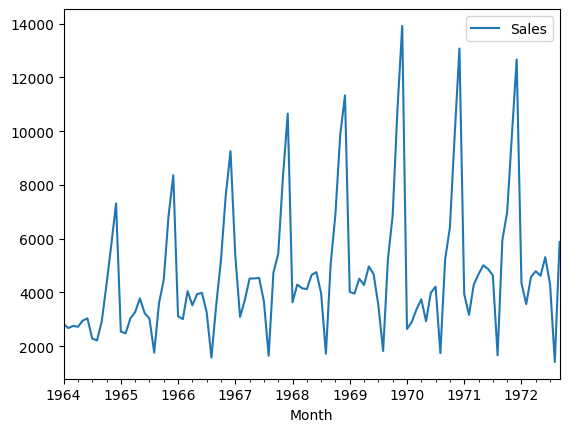

In [17]:
df.plot()

# Checking for Stationarity
Data must be stationary for the time series use case.

**Stationarity** means the statistical properties of the data in a time series do not change over time. It’s a way to measure whether the data has structural patterns like seasonality/trends.


Why is it important to check for stationarity?

- Stationary data is much easier to analyze.

- When forecasting future events, time series models assume that each point is independent of one others. Since stationary data contains no trends or seasonality, the data are considered independent of each other.

So we have to check for stationary before using ARIMA & SARIMAX.

How can we identify stationary data?

There are 2 statistical tests to check the time series data is stationary or not.

1- ADF - Augmented Dickey-Fuller Test

2- Detrending/Differencing

We will conduct Augmented Dickey-Fuller test to check if our data is stationary or not.

How ADF test is conduct?

- The ADF method in statsmodels will output the p-value, the value of the test statistics. If the test statistic is less than the critical value and the p-value is less than the alpha value you set (conventional alpha = 0.05), then there is enough evidence to reject the null hypothesis and state that the time series is stationary.

ADF test -> p-value < 0.05

In [22]:
adfuller(df['Sales'])

(-1.8335930563276215,
 0.36391577166024586,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [23]:
def adfuller_test(sales):
    result = adfuller(sales)

    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']

    for value, label in zip(result, labels):
        print('{} : {} '.format(label, value))

    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, reject the null hypothesis and data is stationary')
    else:
        print('Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary')

In [24]:
adfuller_test(df['Sales'])

ADF test statistics : -1.8335930563276215 
p-value : 0.36391577166024586 
Lags used : 11 
Number of obs used : 93 
Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary


so, p-value = 0.3 < **0.05**

In [25]:
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [26]:
df['Sales'].shift(1)

,Sales
Month,
1964-01-01,NaN
1964-02-01,2815.0
1964-03-01,2672.0
1964-04-01,2755.0
1964-05-01,2721.0
...,...
1972-05-01,4788.0
1972-06-01,4618.0
1972-07-01,5312.0


In [27]:
df['Sales first diff.'] = df['Sales'] - df['Sales'].shift(1)

In [28]:
df.head()

,Sales,Sales first diff.
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [29]:
df['Seasonal first diff.'] = df['Sales'] - df['Sales'].shift(12)

In [30]:
df.head()

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [31]:
adfuller_test(df['Seasonal first diff.'].dropna())

ADF test statistics : -7.626619157213166 
p-value : 2.0605796968136632e-11 
Lags used : 0 
Number of obs used : 92 
Strong evidence against null hypothesis, reject the null hypothesis and data is stationary


<Axes: xlabel='Month'>

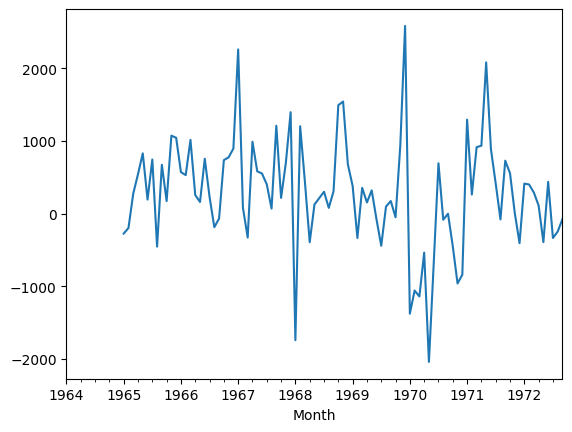

In [32]:
df['Seasonal first diff.'].plot()

# ARIMA

In [33]:
df.head(10)

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


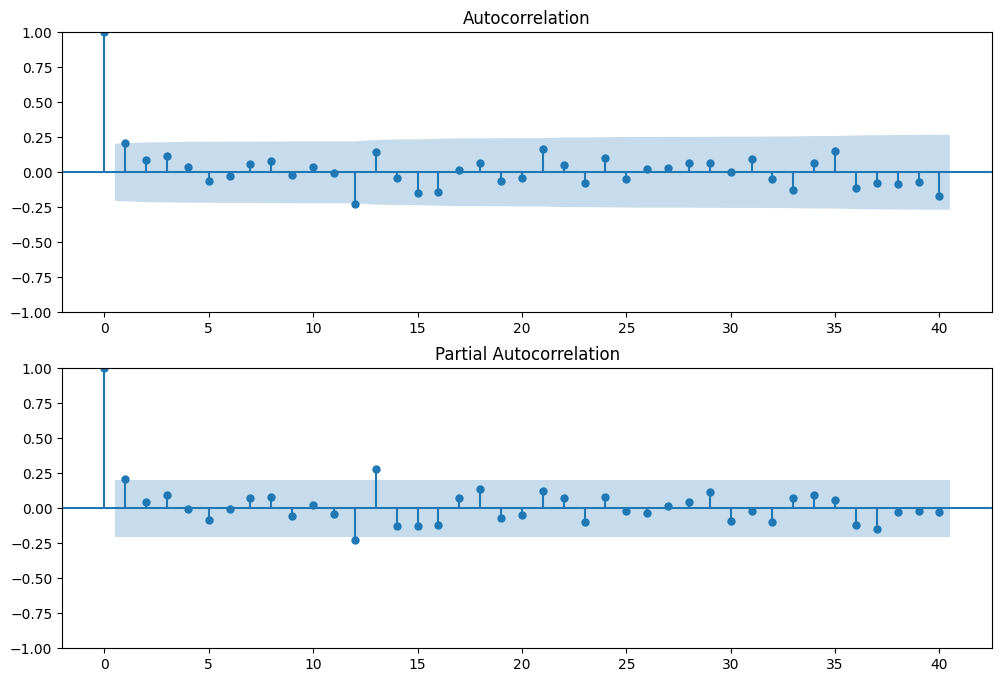

In [36]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal first diff.'].iloc[13:], lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal first diff.'].iloc[13:], lags=40, ax=ax2)

In [42]:
from statsmodels.tsa.arima.model import ARIMA

In [43]:
model = ARIMA(df['Sales'], order=(1,1,1))

In [44]:
model = model.fit()

In [46]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Mon, 12 Aug 2024   AIC                           1911.627
Time:                        11:25:09   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      4.001      0.000       0.232       0.677
ma.L1         -0.9667      0.056    -17.329      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.472      0.0

In [47]:
df['forecast'] = model.predict(start=90, end=103, dynamic=True)

In [48]:
df.head(20)

,Sales,Sales first diff.,Seasonal first diff.,forecast
Month,,,,
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN
1964-06-01,3036.0,90.0,NaN,NaN
1964-07-01,2282.0,-754.0,NaN,NaN
1964-08-01,2212.0,-70.0,NaN,NaN
1964-09-01,2922.0,710.0,NaN,NaN


<Axes: xlabel='Month'>

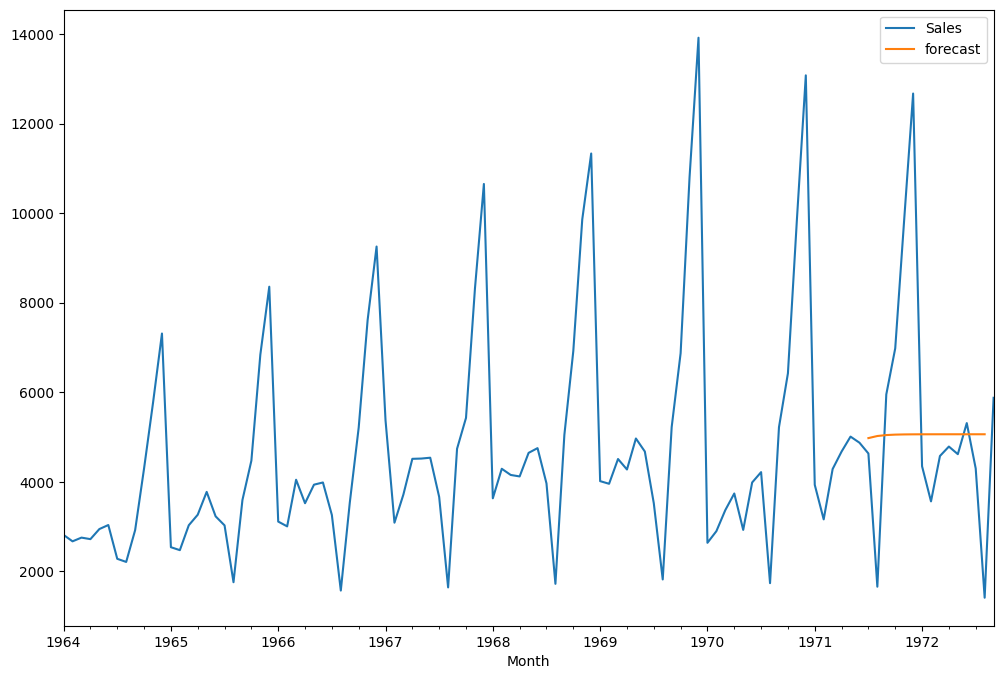

In [49]:
df[['Sales', 'forecast']].plot(figsize=(12,8))

As seen above, ARIMA did not predict it even a little bit closer. The reason behind this is when you have seasonal data ARIMA is not suitable. We will use SARIMAX which is Seasonal ARIMA, it is an extension of ARIMA.



# SARIMAX

SARIMAX is used on data sets that have seasonal cycles. The difference between ARIMA and SARIMAX is the seasonality and exogenous factors (seasonality and regular ARIMA don't mix well).



In [50]:
model = sm.tsa.statespace.SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

In [51]:
results = model.fit()

In [52]:
df['forecast_SARIMAX'] = results.predict(start=90, end=103, dynamic=True)

In [53]:
df.head(20)


,Sales,Sales first diff.,Seasonal first diff.,forecast,forecast_SARIMAX
Month,,,,,
1964-01-01,2815.0,NaN,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN,NaN
1964-06-01,3036.0,90.0,NaN,NaN,NaN
1964-07-01,2282.0,-754.0,NaN,NaN,NaN
1964-08-01,2212.0,-70.0,NaN,NaN,NaN
1964-09-01,2922.0,710.0,NaN,NaN,NaN


<Axes: xlabel='Month'>

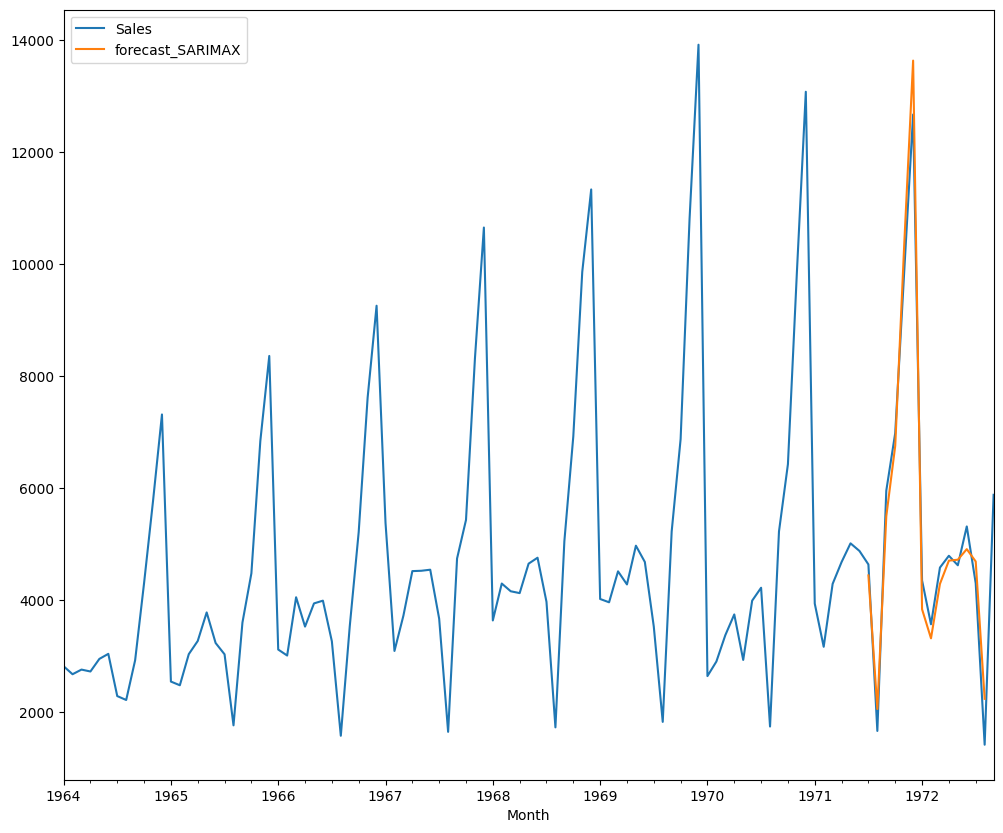

In [54]:
df[['Sales','forecast_SARIMAX']].plot(figsize=(12,10))

As seen above with the plot, SARIMAX was way better and closer to reality than ARIMA to predict sales.



# Making Predictions on Future Data with SARIMAX


In [55]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(0,24)]

In [56]:
future_dates[1:]

[Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [57]:
future_dataset = pd.DataFrame(index = future_dates[1:], columns = df.columns)

In [58]:
future_dataset.tail()

,Sales,Sales first diff.,Seasonal first diff.,forecast,forecast_SARIMAX
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [59]:
future_df = pd.concat([df, future_dataset])

In [60]:
future_df.shape

(128, 5)

In [61]:
future_df['forecast_SARIMAX2'] = results.predict(start=104, end=124, dynamic=True)

<Axes: >

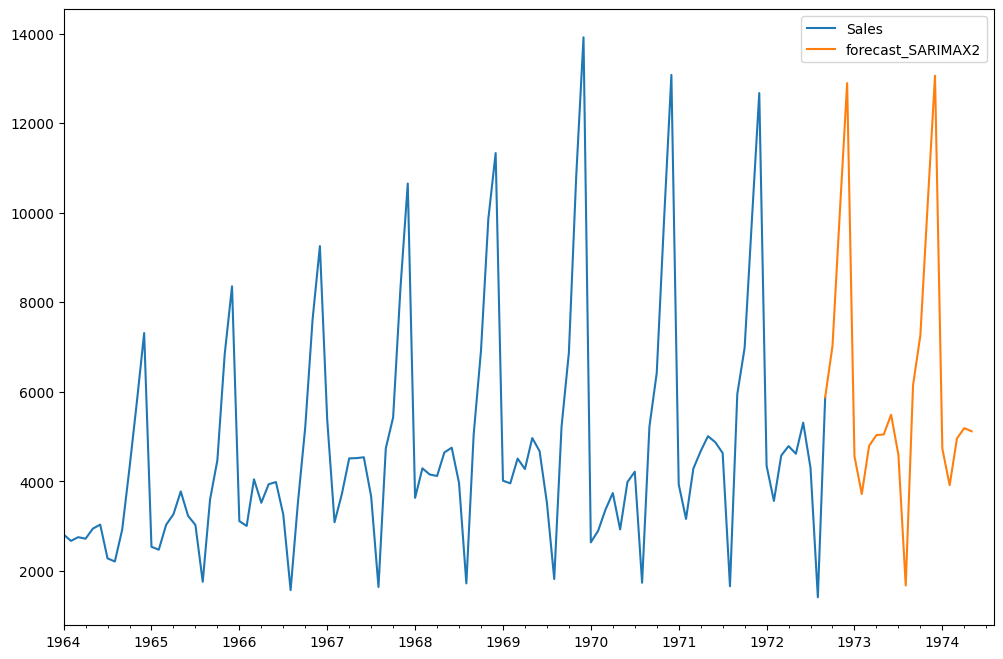

In [62]:
future_df[['Sales', 'forecast_SARIMAX2']].plot(figsize=(12,8))